<a href="https://colab.research.google.com/github/TerraFusion/pytaf/blob/master/examples/notebook/misr2ceres.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyproj==1.9.6
!apt install proj-bin libproj-dev libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/v1.2.0rel.tar.gz
!pip install git+https://github.com/TerraFusion/pytaf.git

     |████████████████████████████████| 2.8MB 4.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/02/cd/b1/a2d6430f74c7a778a43d62f78bec109ca69c732dc9b929142a
Successfully built pyproj
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
Suggested packages:
  libgdal-doc
The following NEW packages will be installed:
  libgeos-dev libproj-dev proj-bin
0 upgraded, 3 newly installed, 0 to remove and 8 not upgraded.
Need to get 305 kB of archives.
After this operation, 1,706 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgeos-dev amd64 3.6.2-1build2 [73.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libproj-dev amd64 4.9.3-2 [199 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 proj-bin amd64 4.9.3-2 [32.3 kB]
Fetched 

  Cloning https://github.com/TerraFusion/pytaf.git to /tmp/pip-req-build-8xa8juog
  Running command git clone -q https://github.com/TerraFusion/pytaf.git /tmp/pip-req-build-8xa8juog
  Stored in directory: /tmp/pip-ephem-wheel-cache-nkavvapi/wheels/89/9a/b7/dbe1239ae21307233b49f0e2c0b9fc92fa251e37d6d1e46624
Successfully built pytaf


In [0]:
import time
start_time = time.time()

In [3]:
!wget https://gamma.hdfgroup.org/ftp/pub/outgoing/joe/data/h5/TERRA_BF_L1B_O53557_20100112014327_F000_V001.sbuset.h5
print("--- %s seconds ---" % (time.time() - start_time))

--2019-06-04 17:14:34--  https://gamma.hdfgroup.org/ftp/pub/outgoing/joe/data/h5/TERRA_BF_L1B_O53557_20100112014327_F000_V001.sbuset.h5
Resolving gamma.hdfgroup.org (gamma.hdfgroup.org)... 206.221.145.35
Connecting to gamma.hdfgroup.org (gamma.hdfgroup.org)|206.221.145.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1384819672 (1.3G) [text/plain]
Saving to: ‘TERRA_BF_L1B_O53557_20100112014327_F000_V001.sbuset.h5’

TERRA_BF_L1B_O53557 100%[===================>]   1.29G  3.81MB/s    in 5m 48s  

2019-06-04 17:20:22 (3.79 MB/s) - ‘TERRA_BF_L1B_O53557_20100112014327_F000_V001.sbuset.h5’ saved [1384819672/1384819672]

--- 349.4554982185364 seconds ---


In [4]:
import h5py
import numpy as np

bf_file = 'TERRA_BF_L1B_O53557_20100112014327_F000_V001.sbuset.h5'
# Read CERES and MISR.
with h5py.File(bf_file) as h5f:
  
  lon_s = h5f['CERES/lon'][:]  
  lat_s = h5f['CERES/lat'][:]
  data_s = h5f['CERES/sza'][:]
  data_v = h5f['CERES/vza'][:]
  
  lon = h5f['MISR/lon'][:]  
  lat = h5f['MISR/lat'][:]
  var = h5f['MISR/var'][:]
print("--- %s seconds ---" % (time.time() - start_time))


--- 370.4897692203522 seconds ---


In [5]:

# Apply criteria.
idx = np.where((data_s>=0)&(data_s<=89)&(data_v>=0)&(data_v<=25))[0]
print(idx.shape)
target_lat = lat_s[idx]
target_lon = lon_s[idx]

# Convert 3-D MISR grids to 2-D.
src_var = np.vstack(var).astype(np.float64)
print(src_var.shape)
src_lat = np.vstack(lat).astype(np.float64)
src_lon = np.vstack(lon).astype(np.float64)

# Call resample using summary interpolation.
sd = np.zeros(src_var.shape, dtype=src_var.dtype)
npix = np.zeros(src_var.shape, dtype=np.int32)
max_radius = 20000

# Make copies of target lat/lon because resample will modify them.
tlat = target_lat.copy()
tlon = target_lon.copy()
print("--- %s seconds ---" % (time.time() - start_time))

(31532,)
(92160, 2048)
--- 376.3913059234619 seconds ---


In [6]:
import pytaf

trg_data = pytaf.resample_s(src_lat, src_lon, target_lat, target_lon, 
                            src_var, max_radius, sd, npix)

print(trg_data.shape)
print(trg_data.size)
print(trg_data)

print("--- %s seconds ---" % (time.time() - start_time))

(31532,)
31532
[-999. -999. -999. ... -999. -999. -999.]
--- 547.3747630119324 seconds ---


In [0]:

# Write data for plotting.
f3 = h5py.File('misr2ceres.h5', 'w')
dset = f3.create_dataset('/Target/Data_Fields/MISR_AN_Red_Radiance', data=trg_data)
dset3 = f3.create_dataset('/Geolocation/Latitude', data=tlat)
dset4 = f3.create_dataset('/Geolocation/Longitude', data=tlon)
f3.close()

--- 549.1157901287079 seconds ---


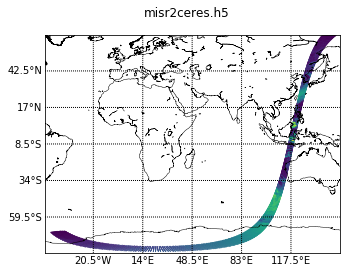

In [8]:
# Open the file.
file_name = 'misr2ceres.h5'

with h5py.File(file_name, 'r') as f:
    # Read MISR Radiance dataset.
    misr_dset = f['/Target/Data_Fields/MISR_AN_Red_Radiance']        
    misr_data = misr_dset[:].astype(np.float64)
    ds_lat = f['/Geolocation/Latitude']
    lat = ds_lat[:].astype(np.float64)
    ds_lon = f['/Geolocation/Longitude']
    lon = ds_lon[:].astype(np.float64)
    
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Plot data.
data = misr_data
data[data == -999] = np.nan
datam = np.ma.masked_array(data, np.isnan(data))
m = Basemap(projection='cyl', resolution='l',
            llcrnrlat=np.min(lat), urcrnrlat=np.max(lat),
            llcrnrlon=np.min(lon), urcrnrlon=np.max(lon))
slat = (np.ceil(np.max(lat)) -  np.floor(np.min(lat))) / 6.0
slon = (np.ceil(np.max(lon)) -  np.floor(np.min(lon))) / 6.0        
m.drawcoastlines(linewidth=0.5)
m.drawparallels(np.arange(np.floor(np.min(lat)),
                          np.ceil(np.max(lat)), slat),
                labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(np.floor(np.min(lon)),
                          np.ceil(np.max(lon)), slon),
                labels=[0, 0, 0, 1])
m.scatter(lon, lat, c=datam, s=1, edgecolors=None, linewidth=0)
fig = plt.gcf()
fig.suptitle('{0}'.format(file_name))
pngfile = file_name+'.py.png'
fig.savefig(pngfile)
print("--- %s seconds ---" % (time.time() - start_time))